In [76]:
import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Aufgabe 1: Bildregistrierung

In [60]:
# read original image
image_gray = plt.imread("../images/Mandrill.jpg")

In [61]:
# define hand-picked points
points = [[100, 100, 1],
          [412, 100, 1],
          [100, 412, 1],
          [412, 412, 1]]

In [62]:
def showcase(transform):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image_gray)
    ax1.scatter(np.array(points)[:, :-2], np.array(points)[:, 1:-1], c="r")

    transformed_image = cv2.warpPerspective(image_gray, transform, (image_gray.shape[0], image_gray.shape[1]))
    transformed_points = np.array([transform @ point for point in points])

    ax2.imshow(transformed_image)
    ax2.scatter(transformed_points[:, :-2], transformed_points[:, 1:-1], c="r")

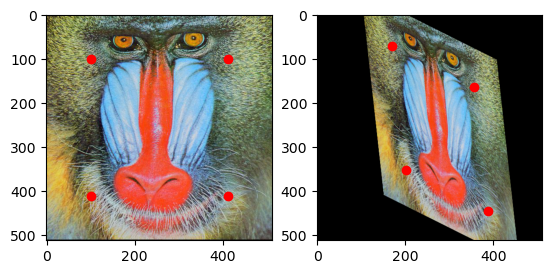

In [63]:
# generate ground truth transform
true_transform = np.array([[0.6, 0.1, 100],
                           [0.3, 0.9, -50],
                           [0, 0, 1]])

transformed_points = np.array([true_transform @ point for point in points])

showcase(true_transform)

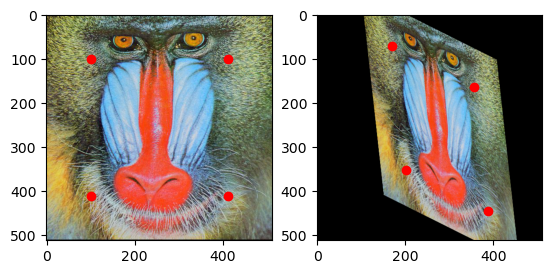

In [64]:
# This is not enough...
M, mask = cv2.findHomography(np.array(points), np.array(transformed_points), cv2.RANSAC)
showcase(M)

In [65]:
# This doesn't work...
# A, res, rank, s = np.linalg.lstsq(np.array(points), np.array(transformed_points), rcond=None)
# showcase(A)

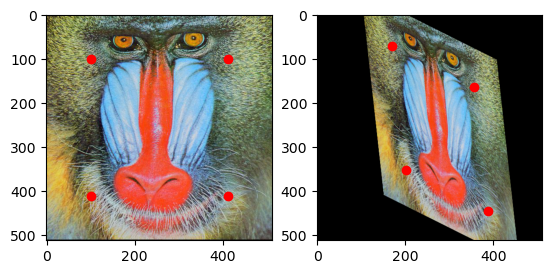

In [66]:
# This I do not fully understand...

# VL4 page 28ff??
# https://de.wikipedia.org/wiki/Bildregistrierung#Globale_Transformationen
# https://math.stackexchange.com/a/1289595
# Still no idea...
pairs = [[[0.0, 0.0, 0.0, -z_t * x, -z_t * y, -z_t * z, y_t * x, y_t * y, y_t * z],
          [z_t * x, z_t * y, z_t * z, 0.0, 0.0, 0.0, -x_t * x, -x_t * y, -x_t * z]]
         for (x, y, z), (x_t, y_t, z_t) in zip(points, transformed_points)]

# concat the pairs by reshaping to a 2d array
matrix = np.array(pairs).reshape(-1, 9)

# The Singular value decomposition computes the Pseudo-Inverse
# The Pseudo-Inverse is a way to solve linear least square problems
#
# https://en.wikipedia.org/wiki/Singular_value_decomposition#Example
# https://en.wikipedia.org/wiki/Singular_value_decomposition#Pseudoinverse
# https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Linear_least-squares
_, _, vh = np.linalg.svd(matrix, full_matrices=True)
affine = vh[-1].reshape((3, 3))

# A) Why does this need to be scaled
# B) Why by this value
estimated_transform = affine / affine[2, 2]

showcase(estimated_transform)

# Aufgabe 2: Zhangs Algorithmus

In [67]:
from Maximum_Likelihood import Maximum_Likelihood, Optimize_Return

images = [cv2.imread(path) for path in glob.glob("../images/chess_images/*.jpg")]
images_gray = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
w, h = 9, 6  # chessboard size
square_side = 12.5  # length of chessboard paper in mm

# Useful:
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf

In [68]:
# Helpers:
def get_b(all_h):
    # See Section 3.1
    # To get B, we need to solve Equation (7)
    # To solve Equation (7), we need to calculate the 2n x 6 V matrix
    # To calculate this 2n x 6 V matrix we need to calculate many v_i_j's
    #
    # With all this there is some pseudo inverse magic to solve shit
    v = np.array([get_v(H) for H in all_h])
    v = v.reshape(-1, 6)  # flatten the pairs
    _, _, vh = np.linalg.svd(v)  # (Equation (9) would be relevant i guess)
    b = vh[-1, :]

    # convert it to 3x3 matrix form
    b11, b12, b22, b13, b23, b33 = b
    return np.array([[b11, b12, b13],
                     [b12, b22, b23],
                     [b13, b23, b33]])


def get_v(H):
    v12 = get_v_i_j(H[:, 0], H[:, 1])
    v11 = get_v_i_j(H[:, 0], H[:, 0])
    v22 = get_v_i_j(H[:, 1], H[:, 1])
    return [v12.T, (v11 - v22).T]  # See equation (8)


def get_v_i_j(hi, hj):
    hi1, hi2, hi3 = hi
    hj1, hj2, hj3 = hj
    # See Equation (7)
    v_i_j = np.array(
        [hi1 * hj1, hi1 * hj2 + hi2 * hj1, hi2 * hj2, hi3 * hj1 + hi1 * hj3, hi3 * hj2 + hi2 * hj3, hi3 * hj3])
    return v_i_j.T


def get_intrinsic(b):
    # see Appendix B
    v0 = (b[0, 1] * b[0, 2] - b[0, 0] * b[1, 2]) / (b[0, 0] * b[1, 1] - b[0, 1] ** 2)
    lambda1 = b[2, 2] - (b[0, 2] ** 2 + v0 * (b[0, 1] * b[0, 2] - b[0, 0] * b[1, 2])) / b[0, 0]
    alpha = np.sqrt(lambda1 / b[0, 0])
    beta = np.sqrt(lambda1 * (b[0, 0] / (b[0, 0] * b[1, 1] - b[0, 1] ** 2)))
    gamma = -(b[0, 1] * alpha ** 2 * beta) / lambda1
    u0 = (gamma * v0 / beta) - (b[0, 2] * alpha ** 2 / lambda1)

    # see 2.1 Notation
    return np.array([[alpha, gamma, u0],
                     [0, beta, v0],
                     [0, 0, 1]])


def get_rotation_translation(A, all_h):
    # See bottom of Section 3.1
    all = []
    for h in all_h:
        h1 = h[:, 0]
        h2 = h[:, 1]
        h3 = h[:, 2]

        lambda1 = np.linalg.norm(np.dot(np.linalg.inv(A), h1), 2)
        r1 = np.dot(np.linalg.inv(A), h1) / lambda1
        r2 = np.dot(np.linalg.inv(A), h2) / lambda1
        r3 = np.cross(r1, r2)
        t = np.dot(np.linalg.inv(A), h3) / lambda1

        all.append(np.array([r1, r2, r3, t]).T)

    return all

In [69]:
def find_corners(image_gray):
    ret, corners = cv2.findChessboardCorners(image_gray, (w, h), None)
    if ret:
        return corners
    else:
        print("No Checkerboard Found")


def find_homography(a, b):
    M, mask = cv2.findHomography(a, b, cv2.RANSAC, 5.0)
    return M

In [77]:
# --- Zhang's Algorithmus ---
# find chessboard corners
all_corners = [find_corners(img) for img in images_gray]

# get world coordinates
Yi, Xi = np.indices((h, w))
offset = 0
corner_coords = np.stack(((Xi.ravel() + offset) * square_side, (Yi.ravel() + offset) * square_side)).T

# denotes all homography matricies for each image
all_h = [find_homography(corner_coords, corner) for corner in all_corners]

# calculate the B matrices
b = get_b(all_h)
# deduce the A matrix from B
a = get_intrinsic(b)
# and calculate the rotation and translation matrices
# TODO do I need Appendix C for this?
all_rt = get_rotation_translation(a, all_h)

# optimization
optimized = Maximum_Likelihood.optimize(all_corners, corner_coords, all_rt, a, all_h)

Init Kc
Initialized kc =
 [[0]
 [0]]
Optimizing ...


IndexError: index 1 is out of bounds for axis 0 with size 1

In [78]:
for image, corners in zip(images, all_corners):
    cv2.drawChessboardCorners(image, (w, h), corners, True)
    cv2.imshow('frame', image)
    cv2.waitKey()
cv2.destroyAllWindows()

In [79]:
# intrinsic parameters
a

array([[ 2.06901035e+03, -3.29535483e+00,  7.61519658e+02],
       [ 0.00000000e+00,  2.05747751e+03,  1.36265530e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [80]:
# extrinsic per image?
all_rt

[array([[ 3.41815599e-02,  9.98416952e-01,  2.92160750e-02,
         -3.43436067e+01],
        [-9.81384248e-01,  2.73636261e-02,  1.89886841e-01,
          3.87856497e+00],
        [ 1.88988305e-01, -3.50397721e-02,  9.80766000e-01,
          2.17008231e+02]]),
 array([[ 3.33711813e-02,  1.00051539e+00, -1.28897764e-02,
         -3.79108445e+01],
        [-9.43342012e-01,  3.49647683e-02,  3.30262207e-01,
          1.09227727e+01],
        [ 3.30139688e-01,  1.42739186e-03,  9.44995021e-01,
          1.96407843e+02]]),
 array([[ 4.04482194e-02,  9.95540215e-01, -6.16169479e-02,
         -3.59419425e+01],
        [-8.94958221e-01,  6.16329214e-02,  4.40783937e-01,
         -1.25522890e+00],
        [ 4.44312643e-01,  3.82505696e-02,  8.93459842e-01,
          1.84503131e+02]]),
 array([[-2.67175154e-03,  9.98417525e-01, -7.53929916e-02,
         -3.41970367e+01],
        [-8.51671559e-01,  3.45655160e-02,  5.23419456e-01,
         -2.14001386e+00],
        [ 5.24069096e-01,  6.72539458

In [74]:
# optimized